In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime
import numpy as np

In [15]:
UNIT = '1'
MARKET = 'USDT-BTC'

data_columns = {
    'market': 'Market',
    'candle_date_time_utc': 'Date',
    'opening_price': 'Open',
    'high_price': 'High',
    'low_price': 'Low',
    'trade_price': 'Close',
    'candle_acc_trade_volume': 'Volume',
    'candle_acc_trade_price' : 'Price',
}

# str UTC DATETIME
def get_query_datetime():
    now = datetime.datetime.now() #- datetime.timedelta(hours=9)
    now = str(now.strftime('%Y-%m-%d %H:%M:%S'))
    now = now.replace(' ', 'T') + 'Z'
    return now


# 크롤링한 데이터 전처리
def preprocessing_crawled_data(datas: str):
    array_dict_datas = []
    array_datas = datas.split('},')

    for data in array_datas:
        array_data = []
        data = data.replace('{', '')
        data = data.replace('}', '')
        array_data = data.split(',')

        dict_data = {}
        for value in array_data:
            tmp = value.split(':', 1)
            if tmp[0][1: -1] in data_columns:
                dict_data[data_columns[tmp[0][1: -1]]] = tmp[1]

        dict_data['Market'] = dict_data['Market'][1: -1]
        dict_data['Date'] = dict_data['Date'][1: -1]
        dict_data['Open'] = float(dict_data['Open'])
        dict_data['High'] = float(dict_data['High'])
        dict_data['Low'] = float(dict_data['Low'])
        dict_data['Close'] = float(dict_data['Close'])
        dict_data['Volume'] = float(dict_data['Volume'])
        dict_data['Price'] = float(dict_data['Price'])
        array_dict_datas.append(dict_data)

    return array_dict_datas


# 크롤링 후 df 리턴
def do_crawl(unit: str, market: str, time: str, count: str, loop: int):
    df = pd.DataFrame([], columns=['Date', 'Market', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price'])
    url = "https://api.upbit.com/v1/candles/minutes/" + unit

    for _ in range(loop):
        querystring = {"market": market, "to": time, "count": count}
        response = requests.request("GET", url, params=querystring)
        df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)
        time = df.iloc[-1]['Date'] + 'Z'
    df = df.loc[::-1].reset_index(drop=True)
    return df




# first 데이터 셋 만들기
df = do_crawl(UNIT, MARKET, get_query_datetime(), '200', 50)
df.to_csv("test.csv")

print(df)

                     Date    Market       Open       High        Low  \
0     2022-03-20T17:44:00  USDT-BTC  41079.239  41079.239  41079.239   
1     2022-03-20T17:46:00  USDT-BTC  41064.831  41064.831  41064.831   
2     2022-03-20T17:47:00  USDT-BTC  41064.831  41080.037  41035.086   
3     2022-03-20T17:48:00  USDT-BTC  41072.141  41072.141  41072.141   
4     2022-03-20T18:03:00  USDT-BTC  40984.183  40984.183  40984.183   
...                   ...       ...        ...        ...        ...   
9995  2022-04-13T06:37:00  USDT-BTC  40105.588  40169.614  40105.588   
9996  2022-04-13T06:38:00  USDT-BTC  40146.749  40148.692  40146.749   
9997  2022-04-13T06:39:00  USDT-BTC  40130.885  40130.885  40116.895   
9998  2022-04-13T06:40:00  USDT-BTC  40116.895  40116.895  40116.895   
9999  2022-04-13T06:41:00  USDT-BTC  40116.896  40124.915  40116.896   

          Close        Volume        Price  
0     41079.239  4.224300e-04    17.353103  
1     41064.831  5.962674e-02  2448.562001  


Text(0, 0.5, 'price')

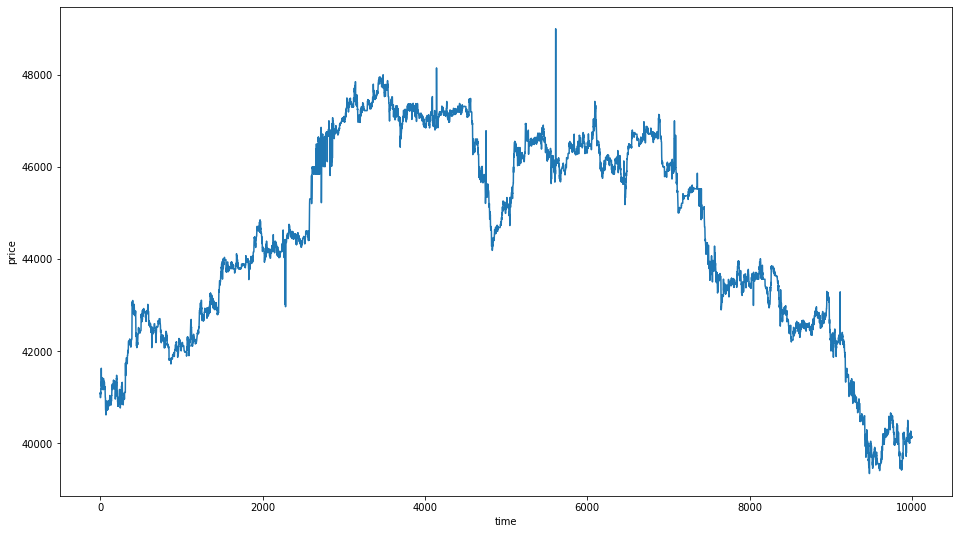

In [16]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

In [17]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

          Open      High       Low     Close        Volume         Price
0     0.200649  0.173279  0.216766  0.180515  8.185803e-05  7.662962e-05
1     0.198971  0.171792  0.215122  0.179024  1.155468e-02  1.081287e-02
2     0.198971  0.173361  0.211729  0.180531  4.347775e-02  4.068861e-02
3     0.199823  0.172547  0.215956  0.179781  8.494281e-03  7.950362e-03
4     0.189581  0.163470  0.205921  0.170679  2.886870e-04  2.696227e-04
...        ...       ...       ...       ...           ...           ...
9995  0.087275  0.079416  0.105678  0.084092  7.363773e-08  6.732812e-08
9996  0.092068  0.077257  0.110374  0.084228  7.751340e-08  7.088813e-08
9997  0.090220  0.075419  0.106968  0.080938  8.332691e-08  7.616791e-08
9998  0.088591  0.073976  0.106968  0.080938  9.819979e-05  8.977402e-05
9999  0.088592  0.074803  0.106968  0.081768  9.301608e-08  8.502006e-08

[10000 rows x 6 columns]


In [18]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.1, random_state=0, shuffle=False)
x_train.shape, y_train.shape
print(type(x_test))
print(x_test)

<class 'pandas.core.frame.DataFrame'>
          Open      High       Low        Volume         Price
9000  0.341202  0.297834  0.354485  1.937835e-09  1.931429e-09
9001  0.336289  0.293480  0.345275  1.168321e-04  1.123686e-04
9002  0.330799  0.288615  0.321954  2.148392e-03  2.065813e-03
9003  0.307865  0.268291  0.321820  2.157043e-04  2.064530e-04
9004  0.307865  0.269712  0.321820  7.751340e-09  7.471531e-09
...        ...       ...       ...           ...           ...
9995  0.087275  0.079416  0.105678  7.363773e-08  6.732812e-08
9996  0.092068  0.077257  0.110374  7.751340e-08  7.088813e-08
9997  0.090220  0.075419  0.106968  8.332691e-08  7.616791e-08
9998  0.088591  0.073976  0.106968  9.819979e-05  8.977402e-05
9999  0.088592  0.074803  0.106968  9.301608e-08  8.502006e-08

[1000 rows x 5 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [19]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)
  

In [20]:
WINDOW_SIZE=5
BATCH_SIZE=64

In [21]:
train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [22]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 5]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [23]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=65)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=1000, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/1000
    134/Unknown - 4s 10ms/step - loss: 0.0128 - mse: 0.0256
Epoch 1: val_loss improved from inf to 0.00381, saving model to tmp/ckeckpointer.ckpt
141/141 [==============================] - 5s 15ms/step - loss: 0.0122 - mse: 0.0245 - val_loss: 0.0038 - val_mse: 0.0076
Epoch 2/1000
137/141 [============================>.] - ETA: 0s - loss: 4.0039e-04 - mse: 8.0078e-04
Epoch 2: val_loss improved from 0.00381 to 0.00059, saving model to tmp/ckeckpointer.ckpt
141/141 [==============================] - 2s 11ms/step - loss: 3.9233e-04 - mse: 7.8466e-04 - val_loss: 5.8791e-04 - val_mse: 0.0012
Epoch 3/1000
132/141 [===========================>..] - ETA: 0s - loss: 8.4214e-05 - mse: 1.6843e-04
Epoch 3: val_loss improved from 0.00059 to 0.00020, saving model to tmp/ckeckpointer.ckpt
141/141 [==============================] - 2s 11ms/step - loss: 8.1397e-05 - mse: 1.6279e-04 - val_loss: 1.9912e-04 - val_mse: 3.9824e-04
Epoch 4/1000
141/141 [==============================] - ETA: 0s -

In [24]:
print("%.7f" % (float(min(history.history['val_loss']))))
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

0.0001666
(995, 1)
(995, 1)


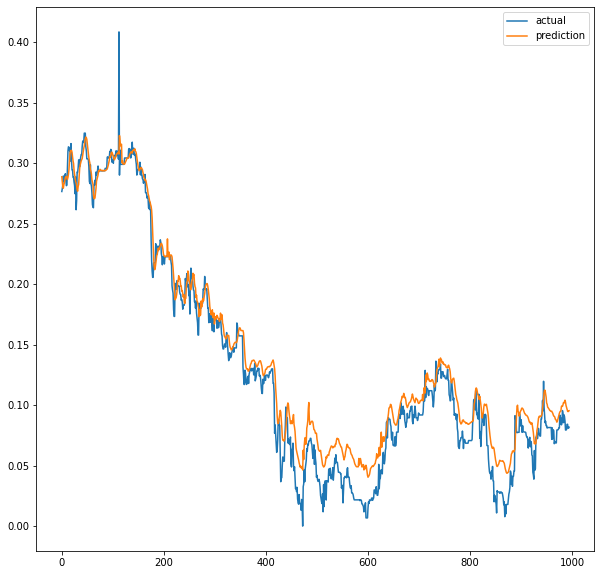

In [25]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [26]:
live_df = do_crawl(UNIT, MARKET, get_query_datetime(), '200', 5)
print(datetime.datetime.now())
print(get_query_datetime())

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price']
scaled = scaler.fit_transform(live_df[scale_cols])
live_scaled_df = pd.DataFrame(scaled, columns=scale_cols)
live_x, live_y = live_scaled_df.drop('Close', 1), live_scaled_df['Close']
live_data = windowed_dataset(live_x, live_y, WINDOW_SIZE, BATCH_SIZE, False)

pred = model.predict(live_data)

# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(pred), 6) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = pred[:,0]
# inverse transform and then select the right field
pred = scaler.inverse_transform(trainPredict_dataset_like)[:,0]

def muzisung_buy(pred_percent: float, live_percent: float, money: float):
    global array_pred_percents
    array_pred_percents.sort()
    if pred_percent > np.mean(array_pred_percents):
        money = money + (money * live_percent / 100)
    return money

2022-04-13 06:47:49.963826
2022-04-13T06:47:49Z


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


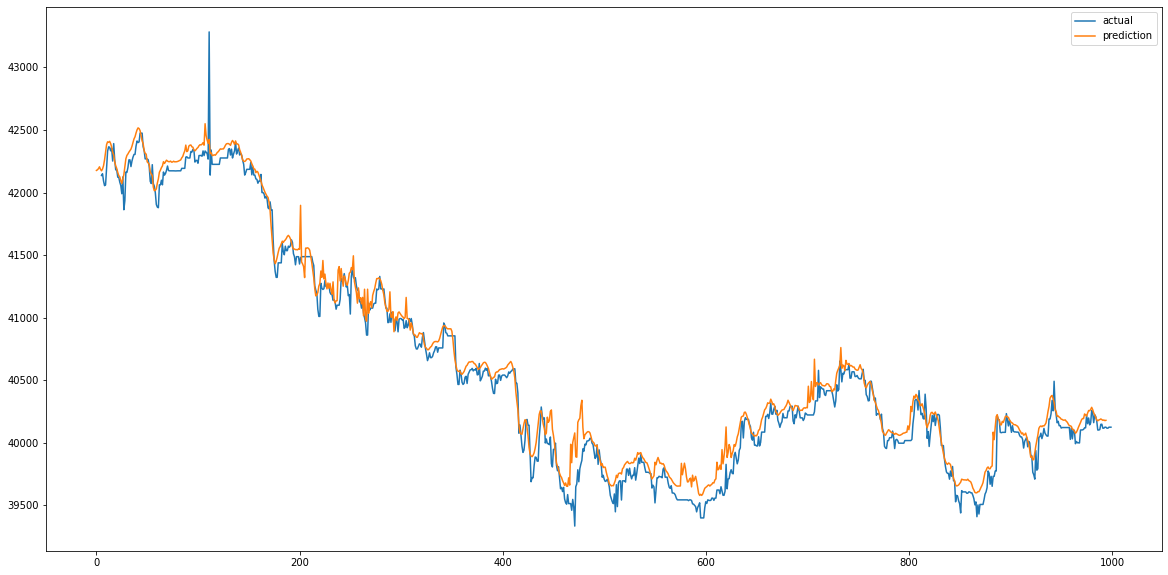

In [27]:
plt.figure(figsize=(20,10))
plt.plot(live_df['Close'][WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()